In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from deepseries.models import BasicSeq2Seq
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl

Text(0.5, 1.0, ' log sin curve with noisy')

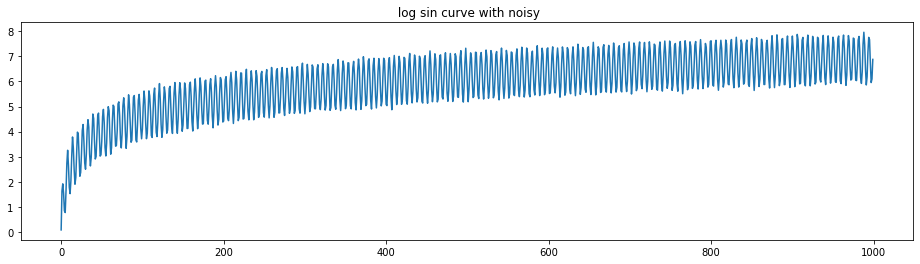

In [2]:
SEQ_LEN = 1000
log_sin = np.sin(np.arange(SEQ_LEN)) + np.log1p(np.arange(SEQ_LEN)) + np.random.normal(0, 0.05, SEQ_LEN)
plt.figure(figsize=(16, 4))
plt.plot(log_sin)
plt.title(" log sin curve with noisy")

In [3]:
# normalize
test_size = 100
valid_size = 100

mu = log_sin[:-200].mean()
std = log_sin[:-200].std()

log_sin = (log_sin - mu) / std

# reshape series shape (n_series, series_len, series_dim)
log_sin = log_sin.reshape(1, -1, 1)

# cut for train / test / valid

enc_len = 100
dec_len = 100

class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(SEQ_LEN), enc_len, dec_len, test_size+valid_size)
valid_idx, test_idx = spliter.split(valid_idx, enc_len, dec_len, test_size)

train_xy = TimeSeries(log_sin[:, train_idx])
valid_xy = TimeSeries(log_sin[:, valid_idx])
test_xy = TimeSeries(log_sin[:, test_idx])

In [4]:
# build data lodaer

train_dl = Seq2SeqDataLoader(train_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=50, mode='train', seq_last=False)
valid_dl = Seq2SeqDataLoader(valid_xy, 32, enc_len, dec_len, use_cuda=True, time_free_space=0, mode='valid', seq_last=False)
test_dl = Seq2SeqDataLoader(test_xy, 32, enc_len, dec_len, use_cuda=True, mode='eval', seq_last=False)

In [5]:
# build model and learner

model = BasicSeq2Seq(1, hidden_dim=32, dropout=0.5, rnn_type='lstm', n_layers=2)
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
# lr_scheduler = ReduceCosineAnnealingLR(opt, 64)
learner = Learner(model, opt, loss_fn, './test', verbose=5000, lr_scheduler=None)
learner.fit(100, train_dl, valid_dl, patient=64, start_save=1, early_stopping=False)

[[04/17/2020 05:24:43 PM]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./test\logs
[[04/17/2020 05:24:49 PM]] epoch 1 / 100, batch 100%, train loss 0.4778, valid loss 0.8546, cost time 0.1 minute
[[04/17/2020 05:24:55 PM]] epoch 2 / 100, batch 100%, train loss 0.4774, valid loss 0.7971, cost time 0.1 minute
[[04/17/2020 05:25:02 PM]] epoch 3 / 100, batch 100%, train loss 0.4620, valid loss 0.7849, cost time 0.1 minute
[[04/17/2020 05:25:09 PM]] epoch 4 / 100, batch 100%, train loss 0.4667, valid loss 0.7660, cost time 0.1 minute
[[04/17/2020 05:25:15 PM]] epoch 5 / 100, batch 100%, train loss 0.4526, valid loss 0.7486, cost time 0.1 minute
[[04/17/2020 05:25:22 PM]] epoch 6 / 100, batch 100%, train loss 0.4128, valid loss 0.4857, cost time 0.1 minute
[[04/17/2020 05:25:29 PM]] epoch 7 / 100, batch 100%, train loss 0.4021, valid loss 0.5105, cost time 0.1 minute
[[04/17/2020 05:25:36 PM]] epoch 8 / 100, batch 100%, train loss 0.4049, valid loss 0.4625, cost time 0.1 minute

[[04/17/2020 05:32:31 PM]] epoch 72 / 100, batch 100%, train loss 0.3446, valid loss 0.3866, cost time 0.1 minute
[[04/17/2020 05:32:37 PM]] epoch 73 / 100, batch 100%, train loss 0.3438, valid loss 0.4672, cost time 0.1 minute
[[04/17/2020 05:32:44 PM]] epoch 74 / 100, batch 100%, train loss 0.3443, valid loss 0.4601, cost time 0.1 minute
[[04/17/2020 05:32:51 PM]] epoch 75 / 100, batch 100%, train loss 0.3442, valid loss 0.4576, cost time 0.1 minute
[[04/17/2020 05:32:57 PM]] epoch 76 / 100, batch 100%, train loss 0.3449, valid loss 0.4595, cost time 0.1 minute
[[04/17/2020 05:33:03 PM]] epoch 77 / 100, batch 100%, train loss 0.3441, valid loss 0.4652, cost time 0.1 minute
[[04/17/2020 05:33:10 PM]] epoch 78 / 100, batch 100%, train loss 0.3446, valid loss 0.4573, cost time 0.1 minute
[[04/17/2020 05:33:16 PM]] epoch 79 / 100, batch 100%, train loss 0.3450, valid loss 0.4580, cost time 0.1 minute
[[04/17/2020 05:33:23 PM]] epoch 80 / 100, batch 100%, train loss 0.3444, valid loss 0.4

In [6]:
learner.load(epoch=68)
learner.model.eval()
pred = learner.model.predict(enc_x=torch.as_tensor(valid_xy.values[:, :100]).float().cuda(), dec_len=100)

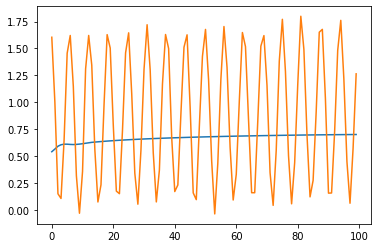

In [7]:
plt.plot(pred.reshape(-1).cpu().numpy())
plt.plot(valid_xy.values[:, 100:].reshape(-1))

In [8]:
valid_xy.values.shape

(1, 200, 1)